# Intro

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipython-input-2884596146.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


## Data

In [2]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')
data

array([[6., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [7., 0., 0., ..., 0., 0., 0.],
       ...,
       [2., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [3]:
labels = data[:,0]
data = data[:,1:]
labels.shape, data.shape

((20000,), (20000, 784))

## Exploration

### Human Readable

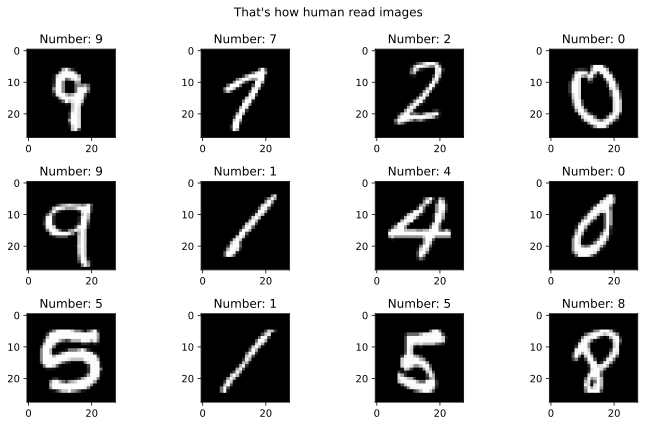

In [4]:
fig, axs = plt.subplots(3,4,figsize = (10, 6))

for ax in axs.flatten():
  random_row = np.random.randint(0, data.shape[0])
  img = np.reshape(data[random_row], (28,28))

  ax.imshow(img, cmap = 'grey')
  ax.set_title(f'Number: %i' %labels[random_row])

plt.suptitle('That\'s how human read images')
plt.tight_layout()
plt.show()

### Computer Readeble

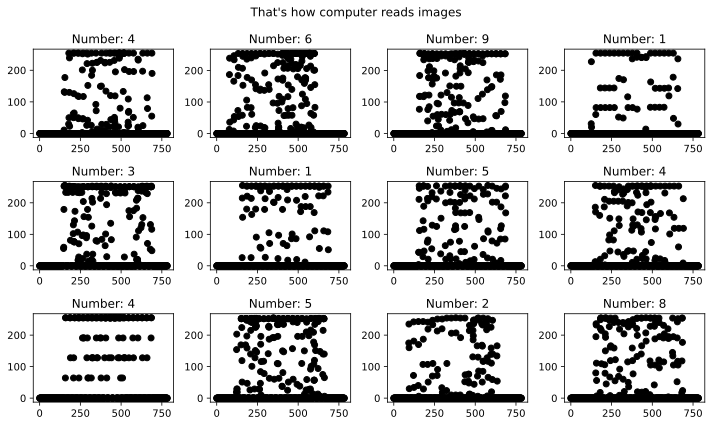

In [5]:
fig, axs = plt.subplots(3,4,figsize = (10,6))

for ax in axs.flatten():
  random_row = np.random.randint(0, data.shape[0])
  ax.plot(data[random_row], 'ko')
  ax.set_title('Number: %i'%labels[random_row])

plt.suptitle('That\'s how computer reads images')
plt.tight_layout()
plt.show()

### Examples 7's

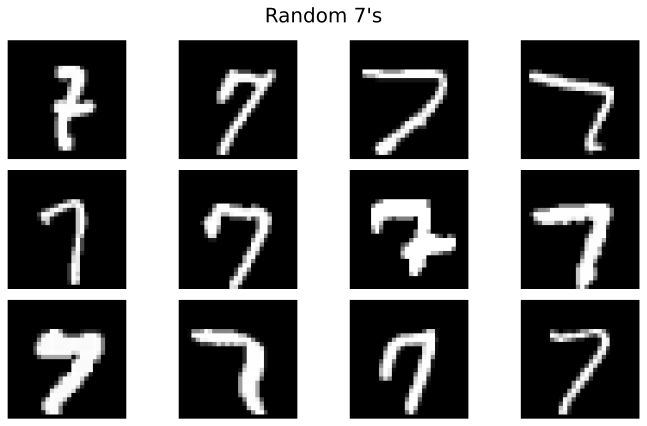

In [6]:
the_7s = data[labels == 7]

fig, axs = plt.subplots(3,4,figsize = (10,6))

for ax in axs.flatten():
  random_7_arr = np.random.randint(0, the_7s.shape[0])
  img = np.reshape(the_7s[random_7_arr], (28,28))

  ax.imshow(img, cmap='grey')
  ax.axis(False)

plt.suptitle('Random 7\'s', fontsize = 20)
plt.tight_layout()
plt.show()

### Plots

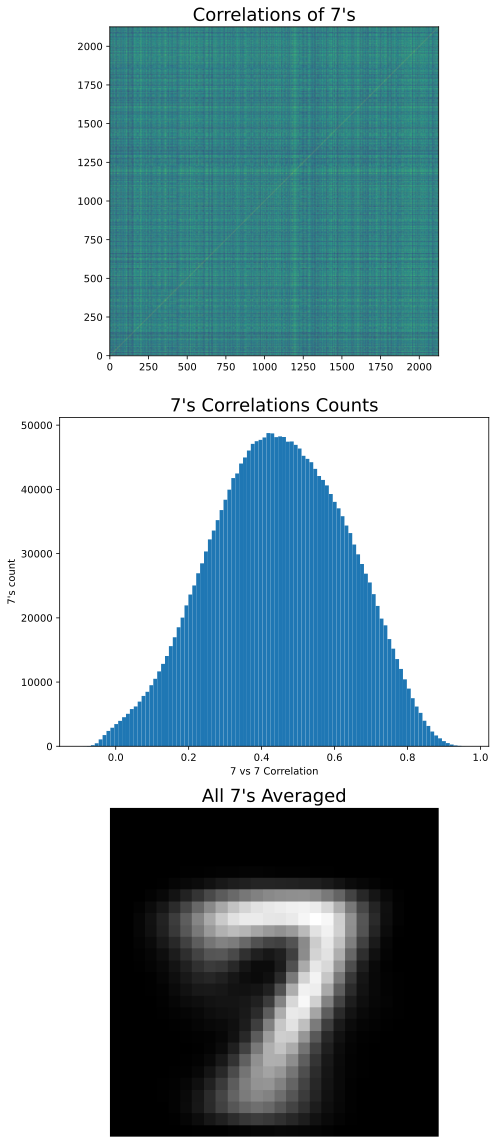

In [7]:
c = np.corrcoef(the_7s)

fig, ax = plt.subplots(3,1,figsize = (7,16))

ax[0].imshow(c, vmin = 0, vmax = 1, origin = 'lower')
ax[0].set_title('Correlations of 7\'s', fontsize = 18)

unq_corr = np.triu(c, k = 1)

ax[1].hist(unq_corr[unq_corr!=0], bins = 100)
ax[1].set_xlabel('7 vs 7 Correlation')
ax[1].set_ylabel('7\'s count')
ax[1].set_title('7\'s Correlations Counts', fontsize = 18)

avg_7s = np.reshape(np.mean(the_7s, axis = 0), (28,28))

ax[2].imshow(avg_7s, cmap = 'grey')
ax[2].axis(False)
ax[2].set_title('All 7\'s Averaged', fontsize = 18)

plt.tight_layout()
plt.show()

###


# FFN to classify digits

* See a simple FFN that reaches ~95% accuracy in MNIST (note: chance performance is 10%)
* Learn about log-softmax and see its advantage over "regular" softmax

## Digits Classification

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

### Data

In [9]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

labels = data[:,0]
data = data[:,1:]

labels = torch.tensor(labels, dtype = torch.long)
data = torch.tensor(data, dtype = torch.float)

# normalization
data_norm = data / torch.max(data)

labels, data_norm

(tensor([6, 5, 7,  ..., 2, 9, 5]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

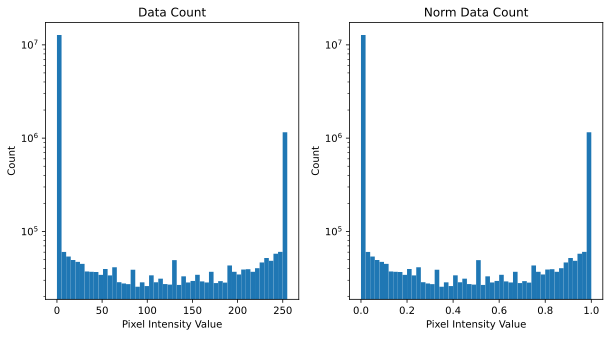

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))

ax[0].hist(data.flatten(), 50)
ax[0].set_title('Data Count')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Pixel Intensity Value')
ax[0].set_yscale('log')

ax[1].hist(data_norm.flatten(), 50)
ax[1].set_title('Norm Data Count')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Pixel Intensity Value')
ax[1].set_yscale('log')

plt.show()

### Split

In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(data_norm, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

In [12]:
print(f'there are {len(train_dataloader)} batches, each with {batch_size} samples.')

there are 250 batches, each with 64 samples.


### Model

In [13]:
data_norm.shape

torch.Size([20000, 784])

In [14]:
def CreateNet():

  class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784, 128)

      self.fc1 = nn.Linear(128,64)
      self.fc2 = nn.Linear(64,64)

      self.output = nn.Linear(64,10)

    def forward(self, x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.output(x)
      return torch.log_softmax(x, axis = 1)

  net = Net()
  loss_fn = nn.NLLLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
  return net, loss_fn, optimizer

CreateNet()

(Net(
   (input): Linear(in_features=784, out_features=128, bias=True)
   (fc1): Linear(in_features=128, out_features=64, bias=True)
   (fc2): Linear(in_features=64, out_features=64, bias=True)
   (output): Linear(in_features=64, out_features=10, bias=True)
 ),
 NLLLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

Let's test model

In [ ]:
net, loss_fn, optimizer = CreateNet()
X, y = next(iter(train_dataloader))
y_hat = net(X)
loss = loss_fn(y_hat, y)
acc = 100 * torch.mean(
    (torch.argmax(y_hat, axis = 1) == y).float()
)
print(f'First spin Accuracy: {acc}% ')

First spin Accuracy: 14.0625% 


### Train

In [ ]:
def ModelTrain(epochs, verbose):
  net, loss_fn, optimizer = CreateNet()

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []

  for epoch in range(epochs):
    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, losses

In [ ]:
train_acc, test_acc, losses = ModelTrain(200, verbose = True)

Epoch: 0 | Train Acc: 13.38 | Test Acc: 18.25 | Loss: 2.30
Epoch: 10 | Train Acc: 85.77 | Test Acc: 86.28 | Loss: 0.49
Epoch: 20 | Train Acc: 91.74 | Test Acc: 91.18 | Loss: 0.29
Epoch: 30 | Train Acc: 93.97 | Test Acc: 92.93 | Loss: 0.21
Epoch: 40 | Train Acc: 95.49 | Test Acc: 94.22 | Loss: 0.16
Epoch: 50 | Train Acc: 96.84 | Test Acc: 94.62 | Loss: 0.12
Epoch: 60 | Train Acc: 97.59 | Test Acc: 94.88 | Loss: 0.09
Epoch: 70 | Train Acc: 98.29 | Test Acc: 95.38 | Loss: 0.07
Epoch: 80 | Train Acc: 98.78 | Test Acc: 95.55 | Loss: 0.06
Epoch: 90 | Train Acc: 99.18 | Test Acc: 95.38 | Loss: 0.04
Epoch: 100 | Train Acc: 99.39 | Test Acc: 95.47 | Loss: 0.03
Epoch: 110 | Train Acc: 99.61 | Test Acc: 95.60 | Loss: 0.02
Epoch: 120 | Train Acc: 99.73 | Test Acc: 95.55 | Loss: 0.02
Epoch: 130 | Train Acc: 99.84 | Test Acc: 95.60 | Loss: 0.01
Epoch: 140 | Train Acc: 99.91 | Test Acc: 95.62 | Loss: 0.01
Epoch: 150 | Train Acc: 99.93 | Test Acc: 95.60 | Loss: 0.01
Epoch: 160 | Train Acc: 99.96 | Tes

### Plot

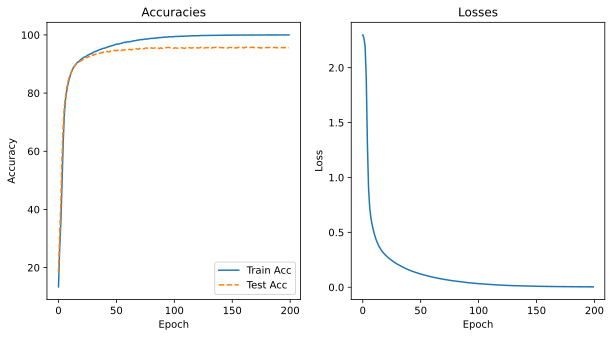

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (10,5))

ax[0].plot(train_acc)
ax[0].plot(test_acc, '--')
ax[0].set_title('Accuracies')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train Acc', 'Test Acc'])

ax[1].plot(losses)
ax[1].set_title('Losses')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.show()

### Inspect More

In [ ]:
X,y = next(iter(test_dataloader))
log_preds = net(X).detach()
preds = torch.exp(log_preds)
torch.max(preds, axis = 1)[1]

tensor([2, 2, 2,  ..., 2, 2, 2])

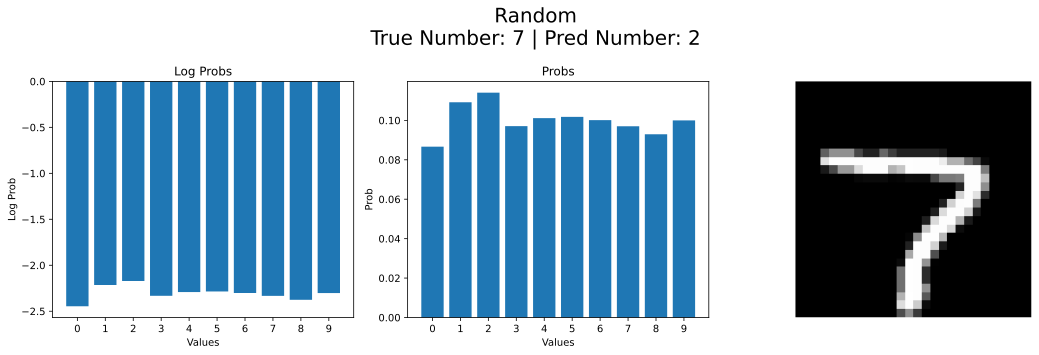

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

random_row = np.random.randint(preds.shape[0])

ax[0].bar(range(10), log_preds[random_row])
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Values')
ax[0].set_ylabel('Log Prob')
ax[0].set_title('Log Probs')

ax[1].bar(range(10), preds[random_row])
ax[1].set_xticks(range(10))
ax[1].set_xlabel('Values')
ax[1].set_ylabel('Prob')
ax[1].set_title('Probs')

img = np.reshape(X[random_row], (28,28))
ax[2].imshow(img, cmap = 'grey')
ax[2].axis(False)

correct_num = y[random_row]
pred_num = torch.max(preds, axis = 1)[1][random_row]

plt.suptitle(f'Random\nTrue Number: {correct_num} | Pred Number: {pred_num}', fontsize = 20)
plt.tight_layout()
plt.show()

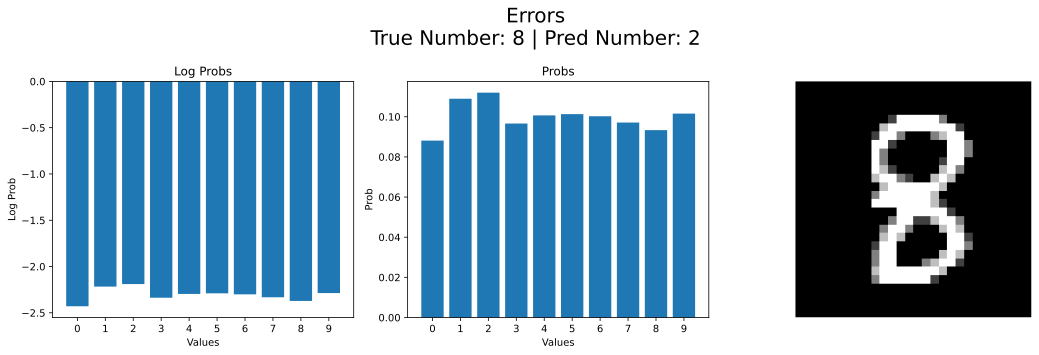

In [ ]:
error_log_preds = log_preds[torch.max(preds, axis = 1)[1] != y]
error_preds = torch.exp(error_log_preds)
error_y = y[torch.max(preds, axis = 1)[1] != y]
error_X = X[torch.max(preds, axis = 1)[1] != y]

fig, ax = plt.subplots(1,3,figsize=(15,5))

random_row = np.random.randint(error_preds.shape[0])

ax[0].bar(range(10), error_log_preds[random_row])
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Values')
ax[0].set_ylabel('Log Prob')
ax[0].set_title('Log Probs')

ax[1].bar(range(10), error_preds[random_row])
ax[1].set_xticks(range(10))
ax[1].set_xlabel('Values')
ax[1].set_ylabel('Prob')
ax[1].set_title('Probs')

img = np.reshape(error_X[random_row], (28,28))
ax[2].imshow(img, cmap = 'grey')
ax[2].axis(False)

correct_num = error_y[random_row]
pred_num = torch.max(error_preds, axis = 1)[1][random_row]

plt.suptitle(f'Errors\nTrue Number: {correct_num} | Pred Number: {pred_num}', fontsize = 20)
plt.tight_layout()
plt.show()

# Classification on binarized data Experiment

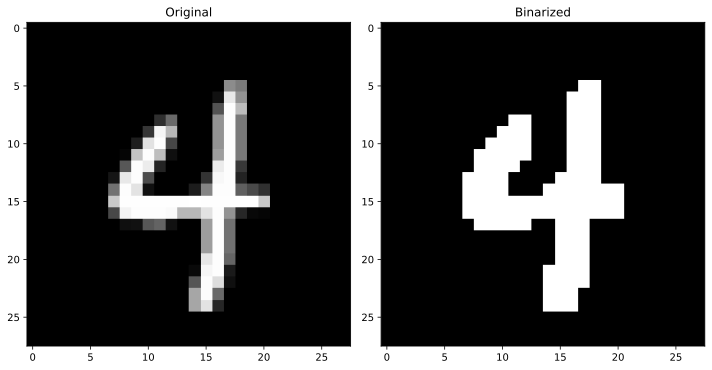

In [ ]:
bin_data = (data > 0)

fig, ax = plt.subplots(1,2,figsize = (10,5))

random_row = np.random.randint(0, bin_data.shape[0])

bin_img = np.reshape(bin_data[random_row], (28,28))
org_img = np.reshape(data[random_row], (28,28))

ax[0].imshow(org_img, cmap = 'grey')
ax[0].set_title('Original')

ax[1].imshow(bin_img, cmap = 'grey')
ax[1].set_title('Binarized')

plt.tight_layout()
plt.show()

In [ ]:
bin_data_norm = bin_data / torch.max(bin_data)

train_data, test_data, train_labels, test_labels = train_test_split(bin_data_norm, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

In [ ]:
bin_train_acc, bin_test_acc, bin_losses = ModelTrain(200, verbose = True)

Epoch: 0 | Train Acc: 12.49 | Test Acc: 24.20 | Loss: 2.30
Epoch: 10 | Train Acc: 88.12 | Test Acc: 87.43 | Loss: 0.40
Epoch: 20 | Train Acc: 91.86 | Test Acc: 91.03 | Loss: 0.27
Epoch: 30 | Train Acc: 94.21 | Test Acc: 92.78 | Loss: 0.20
Epoch: 40 | Train Acc: 95.76 | Test Acc: 93.75 | Loss: 0.14
Epoch: 50 | Train Acc: 97.15 | Test Acc: 94.07 | Loss: 0.11
Epoch: 60 | Train Acc: 98.01 | Test Acc: 94.62 | Loss: 0.08
Epoch: 70 | Train Acc: 98.78 | Test Acc: 94.45 | Loss: 0.06
Epoch: 80 | Train Acc: 99.21 | Test Acc: 94.60 | Loss: 0.04
Epoch: 90 | Train Acc: 99.52 | Test Acc: 94.95 | Loss: 0.03
Epoch: 100 | Train Acc: 99.72 | Test Acc: 94.80 | Loss: 0.02
Epoch: 110 | Train Acc: 99.84 | Test Acc: 94.85 | Loss: 0.01
Epoch: 120 | Train Acc: 99.93 | Test Acc: 95.00 | Loss: 0.01
Epoch: 130 | Train Acc: 99.96 | Test Acc: 94.97 | Loss: 0.01
Epoch: 140 | Train Acc: 99.97 | Test Acc: 94.88 | Loss: 0.01
Epoch: 150 | Train Acc: 99.99 | Test Acc: 94.95 | Loss: 0.00
Epoch: 160 | Train Acc: 99.99 | Tes

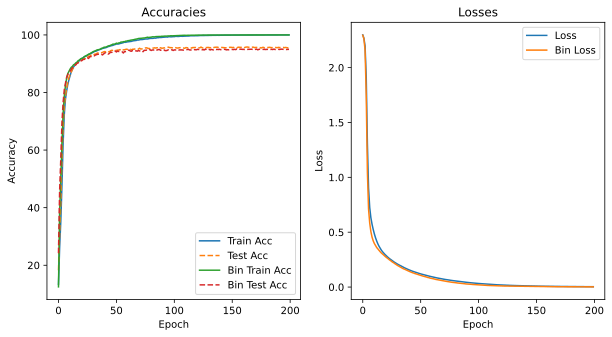

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (10,5))

ax[0].plot(train_acc)
ax[0].plot(test_acc, '--')
ax[0].plot(bin_train_acc)
ax[0].plot(bin_test_acc, '--')
ax[0].set_title('Accuracies')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train Acc', 'Test Acc', 'Bin Train Acc', 'Bin Test Acc'])

ax[1].plot(losses)
ax[1].plot(bin_losses)
ax[1].set_title('Losses')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Loss', 'Bin Loss'])

plt.show()

There is practically no difference between binarized and original data in terms of performance

# Data Normalization Experiment

In [ ]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

labels = data[:,0]
data = data[:,1:]

labels = torch.tensor(labels, dtype = torch.long)
data = torch.tensor(data, dtype = torch.float)

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)

In [ ]:
def loader(train_data, test_data):

  train_dataset = TensorDataset(train_data, train_labels)
  test_dataset = TensorDataset(test_data, test_labels)

  batch_size = 64
  train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
  test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

  return train_dataloader, test_dataloader

In [ ]:
def plot(train_accs, test_accs, train_losses, test_losses, title):
  fig, ax = plt.subplots(1,2,figsize = (10,5))

  ax[0].plot(train_accs)
  ax[0].plot(test_accs, '--')
  ax[0].set_title('Accuracies')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend(['Train Acc', 'Test Acc'])

  ax[1].plot(train_losses)
  ax[1].plot(test_losses)
  ax[1].set_title('Losses')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend(['Train Loss', 'Test Loss'])

  plt.suptitle(title, fontsize = 20)

  plt.show()

In [ ]:
norm_train_data = train_data / torch.max(train_data)
norm_test_data = test_data / torch.max(test_data)

In [ ]:
print('Train data max:',train_data.max())
print('Test data max:',test_data.max())
print('Train norm data max:', norm_train_data.max())
print('Test norm data max:', norm_test_data.max())

Train data max: tensor(255.)
Test data max: tensor(255.)
Train norm data max: tensor(1.)
Test norm data max: tensor(1.)


In [ ]:
def ModelTrain(train_dataloader, test_dataloader, epochs, verbose):
  net, loss_fn, optimizer = CreateNet()

  train_losses = torch.zeros(epochs)
  test_losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []

  for epoch in range(epochs):
    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    train_losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)
      test_loss = loss_fn(y_hat, y)
      test_losses[epoch] = test_loss

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, train_losses, test_losses

#### Normalized Train + Normalized Test

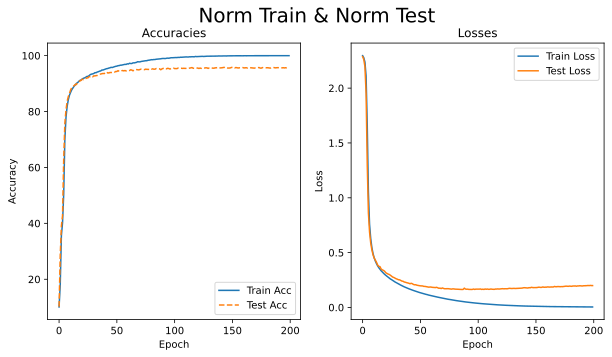

In [ ]:
train_dataloader, test_dataloader = loader(norm_train_data, norm_test_data)
train_accs, test_accs, train_losses, test_losses = ModelTrain(train_dataloader,
                                                              test_dataloader,
                                                              epochs = 200,
                                                              verbose = False)
plot(train_accs, test_accs, train_losses, test_losses, 'Norm Train & Norm Test')

#### Normalized Train + Original Test

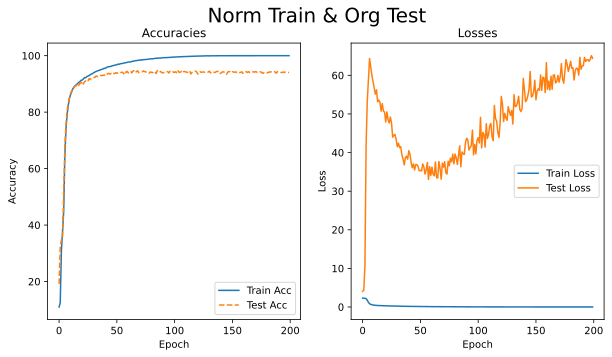

In [ ]:
train_dataloader, test_dataloader = loader(norm_train_data, test_data)
train_accs, test_accs, train_losses, test_losses = ModelTrain(train_dataloader,
                                                              test_dataloader,
                                                              epochs = 200,
                                                              verbose = False)
plot(train_accs, test_accs, train_losses, test_losses, 'Norm Train & Org Test')

#### Original Train + Normalized Test

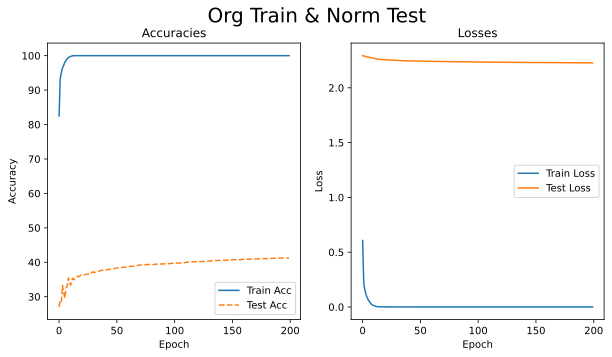

In [ ]:
train_dataloader, test_dataloader = loader(train_data, norm_test_data)
train_accs, test_accs, train_losses, test_losses = ModelTrain(train_dataloader,
                                                              test_dataloader,
                                                              epochs = 200,
                                                              verbose = False)
plot(train_accs, test_accs, train_losses, test_losses, 'Org Train & Norm Test')